# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

### 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [6]:
cap = cv2.VideoCapture(2)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [7]:
!labelme

External WM_DESTROY received for  QWidgetWindow(0x206562b2840, name="LabelDialogClassWindow") , parent:  QWindow(0x0) , transient parent:  QWidgetWindow(0x20655ccc960, name="MainWindowClassWindow")


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [8]:
import tensorflow as tf

In [9]:
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.3 Load Image into TF Data Pipeline

In [10]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [11]:
images.as_numpy_iterator().next()

b'data\\images\\ac740325-c6a2-11ed-a1a1-ccf9e467e269.jpg'

In [12]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [13]:
images = images.map(load_image)

In [14]:
images.as_numpy_iterator().next()

array([[[ 44,  44,  44],
        [ 39,  39,  39],
        [ 38,  38,  38],
        ...,
        [255, 255, 253],
        [254, 255, 255],
        [254, 255, 255]],

       [[ 43,  43,  43],
        [ 43,  43,  43],
        [ 42,  42,  42],
        ...,
        [255, 255, 253],
        [253, 254, 255],
        [254, 255, 255]],

       [[ 40,  40,  40],
        [ 44,  44,  44],
        [ 44,  44,  44],
        ...,
        [255, 255, 253],
        [253, 254, 255],
        [254, 255, 255]],

       ...,

       [[ 14,  14,  14],
        [  7,   7,   7],
        [  7,   7,   7],
        ...,
        [254, 255, 255],
        [255, 255, 255],
        [255, 255, 253]],

       [[  6,   6,   6],
        [  8,   8,   8],
        [  7,   7,   7],
        ...,
        [254, 255, 255],
        [255, 255, 255],
        [255, 255, 253]],

       [[  4,   4,   4],
        [ 10,  10,  10],
        [  3,   3,   3],
        ...,
        [254, 255, 255],
        [255, 255, 255],
        [255, 255, 253]]

In [15]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

In [16]:
image_generator = images.batch(4).as_numpy_iterator()

In [17]:
plot_images = image_generator.next()

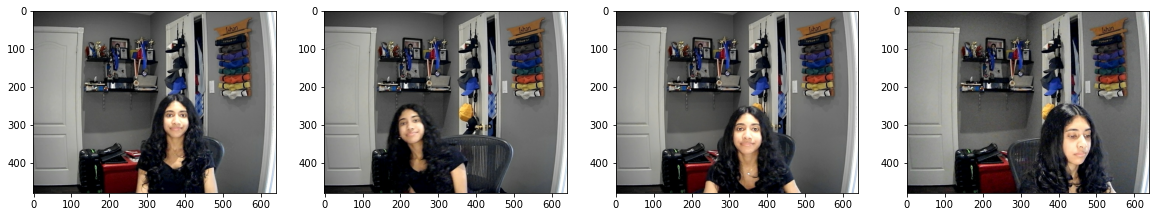

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [ ]:
90*.7 # 63 to train

In [ ]:
90*.15 # 14 and 13 to test and val

### 3.2 Move the Matching Labels

In [19]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [20]:
import albumentations as alb

In [21]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [22]:
img = cv2.imread(os.path.join('data','train', 'images','00054be3-c6a3-11ed-a009-ccf9e467e269.jpg'))

In [23]:
with open(os.path.join('data', 'train', 'labels', '00054be3-c6a3-11ed-a009-ccf9e467e269.json'), 'r') as f:
    label = json.load(f)

In [24]:
label['shapes'][0]['points']

[[271.34730538922156, 240.0], [389.01197604790417, 378.92215568862275]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [25]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [26]:
coords

[271.34730538922156, 240.0, 389.01197604790417, 378.92215568862275]

In [27]:
coords = list(np.divide(coords, [640,480,640,480]))

In [28]:
coords

[0.4239801646706587, 0.5, 0.6078312125748503, 0.7894211576846307]

### 4.4 Apply Augmentations and View Results

In [29]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [30]:
augmented['bboxes'][0][2:]

(0.7547837658017299, 0.8220492348636061)

In [31]:
augmented['bboxes']

[(0.49330671989354624,
  0.5133333333333333,
  0.7547837658017299,
  0.8220492348636061)]

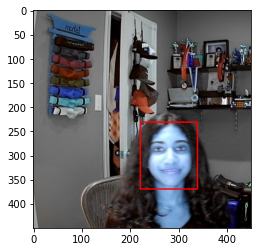

In [32]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [33]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [34]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [35]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [36]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [37]:
train_images.as_numpy_iterator().next()

array([[[0.7011642 , 0.7266544 , 0.7384191 ],
        [0.8410539 , 0.8410539 , 0.83321077],
        [0.83841914, 0.8526348 , 0.85704654],
        ...,
        [0.25018382, 0.25018382, 0.25018382],
        [0.25606617, 0.25606617, 0.25606617],
        [0.2557598 , 0.2557598 , 0.2557598 ]],

       [[0.7802696 , 0.79840684, 0.8072304 ],
        [0.84362745, 0.84405637, 0.8349265 ],
        [0.83621323, 0.85042894, 0.8548407 ],
        ...,
        [0.2627451 , 0.2627451 , 0.2627451 ],
        [0.26715687, 0.26715687, 0.26715687],
        [0.26421568, 0.26421568, 0.26421568]],

       [[0.821875  , 0.8352941 , 0.8372549 ],
        [0.8425858 , 0.84699756, 0.8283701 ],
        [0.76384807, 0.77953434, 0.7834559 ],
        ...,
        [0.27745098, 0.27745098, 0.27745098],
        [0.27493873, 0.27493873, 0.27493873],
        [0.27432597, 0.27432597, 0.27432597]],

       ...,

       [[0.65447307, 0.6979167 , 0.73768383],
        [0.8367034 , 0.84405637, 0.8313113 ],
        [0.82634807, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [38]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [39]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [40]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [41]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [42]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.5444, 0.527 , 0.8057, 0.8354], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [43]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

### 7.2 Create Final Datasets (Images/Labels)

In [44]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [45]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [46]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [47]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.5063, 0.5225, 0.686 , 0.739 ],
        [0.628 , 0.3108, 0.7803, 0.5093],
        [0.    , 0.    , 0.    , 0.    ],
        [0.285 , 0.2095, 0.5137, 0.4983],
        [0.    , 0.    , 0.    , 0.    ],
        [0.5957, 0.291 , 0.7607, 0.4873],
        [0.1143, 0.1753, 0.3306, 0.4834],
        [0.302 , 0.509 , 0.4543, 0.707 ]], dtype=float16))

### 7.3 View Images and Annotations

In [48]:
data_samples = train.as_numpy_iterator()

In [49]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


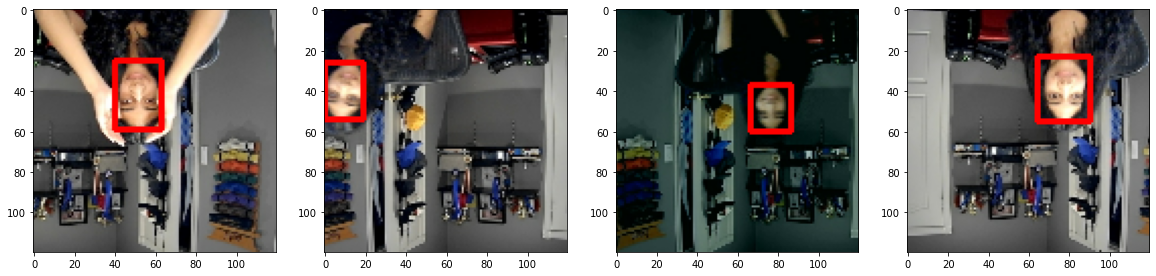

In [50]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [51]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [52]:
vgg = VGG16(include_top=False)

In [53]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [54]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [55]:
facetracker = build_model()

In [56]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [57]:
X, y = train.as_numpy_iterator().next()

In [58]:
X.shape

(8, 120, 120, 3)

In [59]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 1s/step


In [60]:
classes, coords

(array([[0.47184202],
        [0.50042427],
        [0.4152884 ],
        [0.5134824 ],
        [0.57523113],
        [0.53252804],
        [0.45288017],
        [0.40866446]], dtype=float32),
 array([[0.5590164 , 0.3081503 , 0.32355824, 0.5060668 ],
        [0.51335037, 0.30363387, 0.42095098, 0.47498688],
        [0.5096205 , 0.33486444, 0.435922  , 0.54875326],
        [0.49425694, 0.34052277, 0.5029683 , 0.5667646 ],
        [0.4836363 , 0.32379192, 0.4078588 , 0.58925736],
        [0.37180674, 0.272487  , 0.53748834, 0.6690819 ],
        [0.39665124, 0.31541842, 0.50226414, 0.5543155 ],
        [0.46700385, 0.31876662, 0.44634038, 0.49928778]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [61]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [63]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [64]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [65]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [66]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.4727906>

In [67]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6754906>

In [68]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=1.4727906>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [69]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [70]:
model = FaceTracker(facetracker)

In [71]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [72]:
logdir='logs'

In [73]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [74]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 [==============================] - 1031s 2s/step - total_loss: 0.3494 - class_loss: 0.1232 - regress_loss: 0.2879 - val_total_loss: 0.3774 - val_class_loss: 0.1829 - val_regress_loss: 0.2860
Epoch 2/10
473/473 [==============================] - 1390s 3s/step - total_loss: 0.0702 - class_loss: 0.0257 - regress_loss: 0.0574 - val_total_loss: 0.0213 - val_class_loss: 3.5631e-04 - val_regress_loss: 0.0211
Epoch 3/10
473/473 [==============================] - 1663s 3s/step - total_loss: 0.0329 - class_loss: 0.0103 - regress_loss: 0.0277 - val_total_loss: 0.0071 - val_class_loss: 7.1443e-04 - val_regress_loss: 0.0067
Epoch 4/10
473/473 [==============================] - 1645s 3s/step - total_loss: 0.0226 - class_loss: 0.0055 - regress_loss: 0.0198 - val_total_loss: 0.0192 - val_class_loss: 0.0017 - val_regress_loss: 0.0184
Epoch 5/10
473/473 [==============================] - 1815s 4s/step - total_loss: 0.0089 - class_loss: 0.0016 - regress_loss: 0.0081 - val_total_loss: 0

### 10.3 Plot Performance

In [75]:
hist.history

{'total_loss': [0.01318360585719347,
  0.005635354667901993,
  0.011263787746429443,
  0.0011072936467826366,
  0.003226866712793708,
  0.0013841474428772926,
  0.0011824613902717829,
  0.0012549478560686111,
  0.0016749596688896418,
  0.0007474193698726594],
 'class_loss': [0.001259082113392651,
  0.000847207207698375,
  7.421107147820294e-05,
  0.00026218011043965816,
  0.0007648547762073576,
  3.382665818207897e-05,
  8.983181760413572e-05,
  0.0001338189176749438,
  2.3350650735665113e-05,
  1.9923190848203376e-05],
 'regress_loss': [0.012554064393043518,
  0.005211750976741314,
  0.011226681992411613,
  0.0009762035333551466,
  0.0028444393537938595,
  0.0013672341592609882,
  0.0011375454487279058,
  0.001188038382679224,
  0.0016632843762636185,
  0.0007374577689915895],
 'val_total_loss': [0.37743687629699707,
  0.021274227648973465,
  0.007074774708598852,
  0.019228821620345116,
  0.007698956411331892,
  0.01858636736869812,
  0.8736156225204468,
  0.0016988361021503806,
  0.

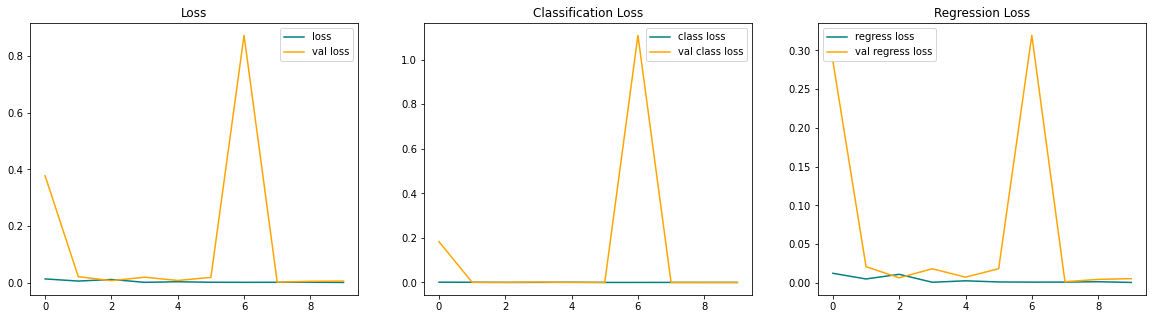

In [76]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [77]:
test_data = test.as_numpy_iterator()

In [78]:
test_sample = test_data.next()

In [79]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 640ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


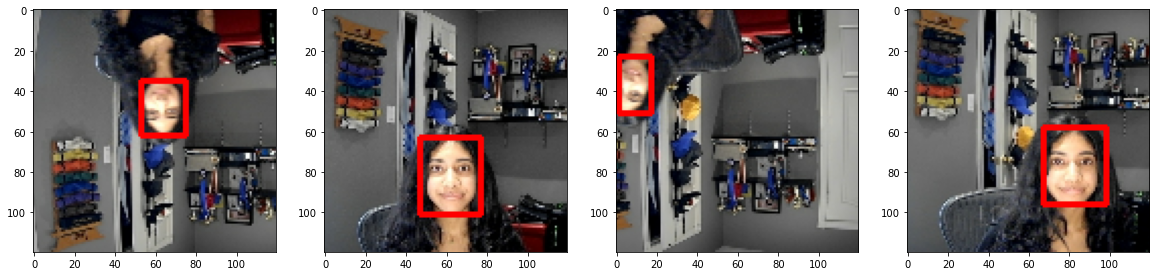

In [80]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [81]:
from tensorflow.keras.models import load_model

In [82]:
facetracker.save('facetracker.h5')

In [83]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [98]:
cap.release()

In [97]:
cap = cv2.VideoCapture(2)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 479ms/step


KeyboardInterrupt: 

In [85]:
cap.release()